In [1]:
import numpy as np
import pandas as pd
import cv2
import torch
import re
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoTokenizer, AutoModel
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.io import read_image
from transformers import ViTModel

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
 
nltk.download('stopwords')

def clean_text(phrase) :
    
    stop_words = set(stopwords.words('english'))
    phrase = phrase.lower()
    phrase = re.sub('[^A-Za-z0-9]+', ' ', phrase)
    word_tokens = word_tokenize(phrase)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    filtered_sentence = []
     
    for w in word_tokens:
        if w not in stop_words:
            if set(w) != {'x'} :
                filtered_sentence.append(w)
    
    filtered_sentence = ' '.join(filtered_sentence)
    filtered_sentence = filtered_sentence.replace('year old', "")
    filtered_sentence = filtered_sentence.replace('nan', "")
    return filtered_sentence

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/manasamangipudi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
reports = pd.read_csv('archive/indiana_reports.csv')
image_files = pd.read_csv('archive/indiana_projections.csv')

reports['findings'] = reports['findings'].apply(lambda x : x if x != None else '')
reports['indication'] = reports['indication'].apply(lambda x : x if x != None else '')
reports['findings'] = reports['findings'].apply(lambda x : str(' ') + str(x)) 
reports['text'] = reports['indication'] + reports['findings']

filtered_reports = reports[~reports['text'].isna()]

filtered_reports['text'] = filtered_reports['text'].apply(lambda x : clean_text(x))
filtered_reports['label'] = filtered_reports['Problems'].apply(lambda x : 'normal' if x == 'normal' else 'diseased')
filtered_reports['class'] = filtered_reports['label'].apply(lambda x : 0 if x == 'normal' else 1)

uids = filtered_reports['uid'].unique()
all_images = []
all_text = []
all_labels = []
all_orient = []
all_uids = []


for each in range(len(filtered_reports)): 

    image_df = image_files[image_files['uid'] == filtered_reports.iloc[each, 0]]

       
    for i in range(len(image_df)) :
       
        all_images.append(image_df.iloc[i, 1])
        all_text.append(filtered_reports.iloc[each, 8])
        all_orient.append(image_df.iloc[i,2])
        all_labels.append(filtered_reports.iloc[each, 2])
        all_uids.append(filtered_reports.iloc[each, 0])
        

/var/folders/rp/w7dswjqx7yd_48lc7m55s2wr0000gn/T/ipykernel_1869/766774814.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_reports['text'] = filtered_reports['text'].apply(lambda x : clean_text(x))
/var/folders/rp/w7dswjqx7yd_48lc7m55s2wr0000gn/T/ipykernel_1869/766774814.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_reports['label'] = filtered_reports['Problems'].apply(lambda x : 'normal' if x == 'normal' else 'diseased')
/var/folders/rp/w7dswjqx7yd_48lc7m55s2wr0000gn/T/ipykerne

In [4]:
dataset_df = pd.DataFrame({'images' : all_images, 'text': all_text, 'orient' : all_orient, 'label' : all_labels, 'uid': all_uids})
dataset_df['label'] = dataset_df['label'].apply(lambda x : 'normal' if x == 'normal' else 'diseased')
dataset_df['class'] = dataset_df['label'].apply(lambda x : 0 if x == 'normal' else 1)
#unique_data = dataset.groupby('uid').first()
#unique_data =unique_data.reset_index()

In [5]:
class ChestXrayClassifier(nn.Module):
    def __init__(self, clip_model, hidden_dim=512):
        super().__init__()
        self.clip_model = clip_model
        
        # Freeze CLIP model weights
        for param in self.clip_model.parameters():
            param.requires_grad = False
            
        # Combined dimension for concatenated features
        combined_dim = 512 * 2  # Since each projection outputs 256
        
        # Neural network classifier after CLIP
        self.classifier = nn.Sequential(
            nn.Linear(combined_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            #nn.Dropout(0.2),
            
            nn.Linear(hidden_dim, hidden_dim//4),
            nn.BatchNorm1d(hidden_dim//4),
            nn.ReLU(),
            #nn.Dropout(0.2),
            
            nn.Linear(hidden_dim//4, 2)
        )
        
    def forward(self, image_features, text_features):
        # Ensure features are normalized
        image_features = F.normalize(image_features, dim=1)
        text_features = F.normalize(text_features, dim=1)
        combined = torch.cat([image_features, text_features], dim=1)
        return self.classifier(combined)

class CLIPModel(nn.Module):
    def __init__(self, dropout,temperature=0.07):
        super().__init__()
        
        # self.image_encoder = models.resnet50(weights='IMAGENET1K_V1')
       
        # self.image_encoder.fc = nn.Linear(2048, 512)  # 512 dimensions

        self.image_encoder = ViTModel.from_pretrained('google/vit-base-patch16-224')
        #self.image_projection = nn.Linear(768, 512)  # ViT outputs 768-dim features
        
        
        self.text_encoder = AutoModel.from_pretrained('bert-base-uncased')
        #self.text_projection = nn.Linear(768, 512)  # 512 dimensions
        self.image_projection = nn.Sequential(
            nn.Linear(768, 768),  # Same size first
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(768, 512)
        )
        
        self.text_projection = nn.Sequential(
            nn.Linear(768, 768),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(768, 512)
        )
        self.temperature = temperature
        
    def encode_image(self, image):
        # image_features = self.image_encoder(image)
        # return F.normalize(image_features, dim=-1)
        
        image_features = self.image_encoder(image).last_hidden_state[:, 0, :]  # Get [CLS] token
        image_features = self.image_projection(image_features)
        return F.normalize(image_features, dim=-1)
        
    
    def encode_text(self, input_ids, attention_mask):
        text_features = self.text_encoder(input_ids=input_ids, 
                                        attention_mask=attention_mask).last_hidden_state[:, 0, :]
        text_features = self.text_projection(text_features)
        return F.normalize(text_features, dim=-1)
    
    def forward(self, image, input_ids, attention_mask):
        image_features = self.encode_image(image)
        text_features = self.encode_text(input_ids, attention_mask)
        #print(text_features.shape, image_features.shape)
        similarity = torch.matmul(text_features, image_features.t())
        
        return similarity



#def train_model(model, train_loader, val_loader, num_epochs=10):

In [6]:
def handle_grayscale(x):
    return x.repeat(3, 1, 1) if x.shape[0] == 1 else x


class TextImageClassifierDataset(Dataset):
    def __init__(self, dataset, transform=None, max_length=128):
        self.image_paths = dataset['images']
        self.texts = dataset['text']
        self.labels = dataset['class']
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.Lambda(handle_grayscale),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        self.max_length = max_length
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = self.transform(read_image('archive/images/images_normalized/' + self.image_paths[idx]).float()/255.0)
        
        text = self.texts[idx]
        label = self.labels[idx]
        tokens = self.tokenizer(text, 
                              padding='max_length',
                              max_length=self.max_length,
                              truncation=True,
                              return_tensors='pt')
        
        return {
            'image': image,
            'input_ids': tokens['input_ids'].squeeze(),
            'attention_mask': tokens['attention_mask'].squeeze(), 
            'label' : label
        }


In [7]:
train_dataset = torch.load('classifier-results/train_dataset.pt')
test_dataset = torch.load('classifier-results/test_dataset.pt')
val_dataset = torch.load('classifier-results/val_dataset.pt')

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=0)

In [8]:
clip_model = CLIPModel(dropout = 0.3, temperature = 0.1)
clip_model.load_state_dict(torch.load('best-clip-results/best_clip_model.pt', map_location=torch.device('cpu')))
classifier_model = ChestXrayClassifier(clip_model = clip_model)
classifier_model.load_state_dict(torch.load('classifier-results/classifier_weights_best.pt', map_location=torch.device('cpu')))

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [11]:
device = torch.device('cpu')
classifier_model.eval()
test_loss = 0
test_correct = 0
test_total = 0
criterion = nn.CrossEntropyLoss()

# Initialize metrics storage
all_labels = []
all_predictions = []
all_probabilities = []

with torch.no_grad():
    for batch in test_dataloader:
        pixel_values = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        image_features = classifier_model.clip_model.encode_image(pixel_values)
        text_features = classifier_model.clip_model.encode_text(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        outputs = classifier_model(image_features, text_features)
        loss = criterion(outputs, labels)
        
        # Calculate accuracy metrics
        test_loss += loss.item()
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()
        
        # Store predictions and labels for overall metrics
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
all_probabilities = np.array(all_probabilities)

# Calculate metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc

# Overall Accuracy
accuracy = test_correct/test_total
print(f'Test Accuracy: {accuracy:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
print('\nConfusion Matrix:')
print(conf_matrix)

# Detailed Classification Report
print('\nClassification Report:')
print(classification_report(all_labels, all_predictions, target_names=['Normal', 'Diseased']))

# ROC-AUC Score
roc_auc = roc_auc_score(all_labels, all_probabilities[:, 1])
print(f'\nROC-AUC Score: {roc_auc:.4f}')

# Calculate Precision-Recall AUC
precision, recall, _ = precision_recall_curve(all_labels, all_probabilities[:, 1])
pr_auc = auc(recall, precision)
print(f'Precision-Recall AUC: {pr_auc:.4f}')

# Per-class metrics
for i, class_name in enumerate(['Normal', 'Diseased']):
    class_mask = all_labels == i
    class_correct = np.sum((all_predictions == i) & class_mask)
    class_total = np.sum(class_mask)
    class_accuracy = class_correct / class_total
    print(f'\n{class_name} Class Accuracy: {class_accuracy:.4f}')

# Calculate average loss
avg_loss = test_loss / len(test_dataloader)
print(f'\nAverage Test Loss: {avg_loss:.4f}')

# Optional: Save metrics to file
metrics_dict = {
    'accuracy': accuracy,
    'roc_auc': roc_auc,
    'pr_auc': pr_auc,
    'confusion_matrix': conf_matrix.tolist(),
    'avg_loss': avg_loss
}

# Save metrics
import json
with open('test_metrics.json', 'w') as f:
    json.dump(metrics_dict, f, indent=4)

Test Accuracy: 0.8314

Confusion Matrix:
[[302  75]
 [110 610]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.73      0.80      0.77       377
    Diseased       0.89      0.85      0.87       720

    accuracy                           0.83      1097
   macro avg       0.81      0.82      0.82      1097
weighted avg       0.84      0.83      0.83      1097


ROC-AUC Score: 0.9093
Precision-Recall AUC: 0.9477

Normal Class Accuracy: 0.8011

Diseased Class Accuracy: 0.8472

Average Test Loss: 0.3682


In [15]:
import numpy as np
import torch
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model):
        self.model = model
        self.gradients = []
        self.activations = []
        
        def forward_hook(module, input, output):
            self.activations.append(output[0])
            return None

        def backward_hook(module, grad_input, grad_output):
            self.gradients.append(grad_output[0])
            return None

        # Register hooks on the last attention layer
        target_layer = self.model.clip_model.image_encoder.encoder.layer[-1]
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_full_backward_hook(backward_hook)
    
    def generate_cam(self, input_image, input_text, target_class=None):
        self.gradients = []
        self.activations = []
        
        # Get model predictions
        self.model.eval()
        image_features = self.model.clip_model.encode_image(input_image)
        text_features = self.model.clip_model.encode_text(
            input_ids=input_text['input_ids'],
            attention_mask=input_text['attention_mask']
        )
        
        outputs = self.model(image_features, text_features)
        
        if target_class is None:
            target_class = outputs.argmax(dim=1).item()
            
        # Clear existing gradients
        self.model.zero_grad()
        
        # Get target class score and backward
        target_score = outputs[0][target_class]
        target_score.backward()

        # Get the gradients and activations
        gradients = self.gradients[0].detach().cpu().numpy()  # (1, 197, 768)
        activations = self.activations[0].detach().cpu().numpy()  # (1, 197, 768)
        
        # Remove batch dimension and CLS token
        gradients = gradients[0, 1:, :]  # (196, 768)
        activations = activations[0, 1:, :]  # (196, 768)
        
        # Pool over the embedding dimension
        pooled_gradients = np.mean(gradients, axis=1)  # (196,)
        pooled_activations = np.mean(activations, axis=1)  # (196,)
        
        # Weight the activations by the gradients
        weights = F.softmax(torch.from_numpy(pooled_gradients), dim=0).numpy()
        cam = weights * pooled_activations
        
        # Reshape into square grid
        n_patches = int(np.sqrt(gradients.shape[0]))
        cam = cam.reshape(n_patches, n_patches)
        
        # Resize to image size and apply ReLU
        cam = cv2.resize(cam, (224, 224))
        cam = np.maximum(cam, 0)
        
        # Normalize between 0 and 1
        if cam.max() != cam.min():
            cam = (cam - cam.min()) / (cam.max() - cam.min())
        else:
            cam = np.zeros_like(cam)
            
        return cam, target_class

def visualize_gradcam(image_tensor, cam, save_path=None):
    # Convert image tensor to numpy array
    image = image_tensor.cpu().numpy().transpose(1, 2, 0)
    image = (image - image.min()) / (image.max() - image.min())
    
    # Create heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = heatmap / 255.0
    
    # Combine original image and heatmap
    result = image * 0.7 + heatmap * 0.3
    result = result / result.max()
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(cam, cmap='jet')
    plt.title('GradCAM Heatmap')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(result)
    plt.title('Overlay')
    plt.axis('off')
    
    plt.show()

def apply_gradcam(model, image_tensor, text_tokens, target_class=None):
    grad_cam = GradCAM(model)
    cam, predicted_class = grad_cam.generate_cam(
        input_image=image_tensor.unsqueeze(0),
        input_text=text_tokens,  # Changed this to match the parameter name
        target_class=target_class
    )
    visualize_gradcam(image_tensor, cam)
    return cam, predicted_class

# Testing code
test_batch = next(iter(test_dataloader))
image = test_batch['image'][0]
text_tokens = {
    'input_ids': test_batch['input_ids'][0:1],
    'attention_mask': test_batch['attention_mask'][0:1]
}
true_label = test_batch['label'][0].item()

# Apply GradCAM
cam, predicted_class = apply_gradcam(
    model=classifier_model,
    image_tensor=image,
    text_tokens=text_tokens
)

# Print results
class_names = ['normal', 'diseased']
print(f"True class: {class_names[true_label]}")
print(f"Predicted class: {class_names[predicted_class]}")
print("\nText input:")
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
text = tokenizer.decode(text_tokens['input_ids'][0], skip_special_tokens=True)
print(text)

IndexError: list index out of range

In [10]:

# Testing code
test_batch = next(iter(test_dataloader))
image = test_batch['image'][0]
text_tokens = {
    'input_ids': test_batch['input_ids'][0:1],
    'attention_mask': test_batch['attention_mask'][0:1]
}
true_label = test_batch['label'][0].item()

# Apply GradCAM
cam, predicted_class = apply_gradcam(
    model=classifier_model,
    image_tensor=image,
    text_tokens=text_tokens
)

# Print results
class_names = ['normal', 'diseased']
print(f"True class: {class_names[true_label]}")
print(f"Predicted class: {class_names[predicted_class]}")
print("\nText input:")
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
text = tokenizer.decode(text_tokens['input_ids'][0], skip_special_tokens=True)
print(text)

IndexError: list index out of range

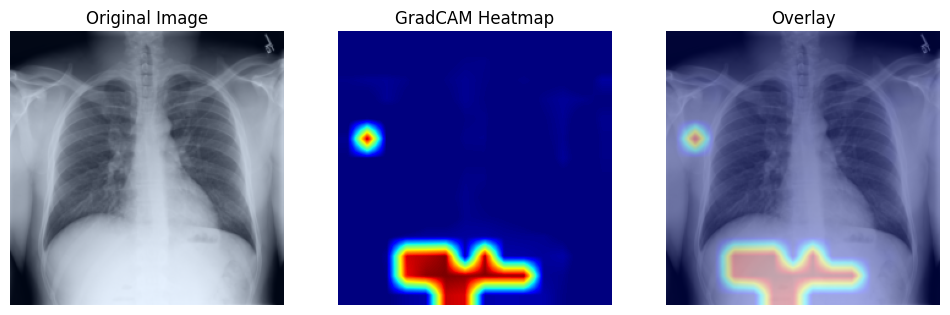

True class: normal
Predicted class: normal

Text input:
male hemoptysis chest pain shortness breath cardiac mediastinal appear normal visible pneumothorax focal airspace opacity pleural effusion seen visible free air diaphragm osseous structures appear intact


In [57]:

# Testing code
test_batch = next(iter(test_dataloader))
image = test_batch['image'][0]
text_tokens = {
    'input_ids': test_batch['input_ids'][0:1],
    'attention_mask': test_batch['attention_mask'][0:1]
}
true_label = test_batch['label'][0].item()

# Apply GradCAM
cam, predicted_class = apply_gradcam(
    model=classifier_model,
    image_tensor=image,
    text_tokens=text_tokens
)

# Print results
class_names = ['normal', 'diseased']
print(f"True class: {class_names[true_label]}")
print(f"Predicted class: {class_names[predicted_class]}")
print("\nText input:")
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
text = tokenizer.decode(text_tokens['input_ids'][0], skip_special_tokens=True)
print(text)

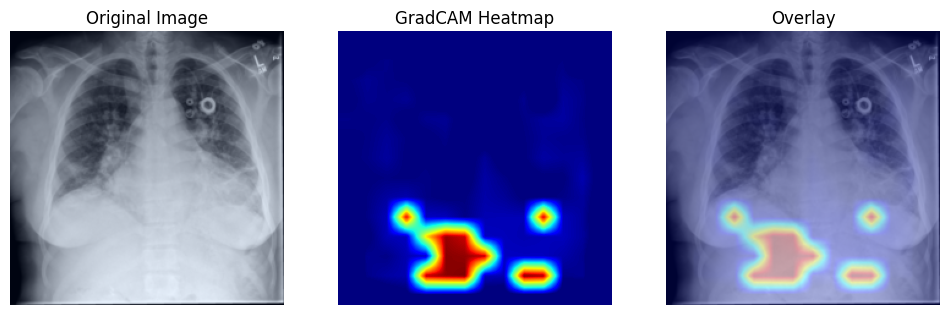

True class: diseased
Predicted class: diseased

Text input:
male shortness breath bilateral patchy pulmonary opacities noted interval improvement left base consolidative opacity pulmonary vascular congestion noted stable enlarged cardiomediastinal silhouette stable left evidence pneumothorax large pleural effusions


In [58]:

# Testing code
test_batch = next(iter(test_dataloader))
image = test_batch['image'][0]
text_tokens = {
    'input_ids': test_batch['input_ids'][0:1],
    'attention_mask': test_batch['attention_mask'][0:1]
}
true_label = test_batch['label'][0].item()

# Apply GradCAM
cam, predicted_class = apply_gradcam(
    model=classifier_model,
    image_tensor=image,
    text_tokens=text_tokens
)

# Print results
class_names = ['normal', 'diseased']
print(f"True class: {class_names[true_label]}")
print(f"Predicted class: {class_names[predicted_class]}")
print("\nText input:")
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
text = tokenizer.decode(text_tokens['input_ids'][0], skip_special_tokens=True)
print(text)

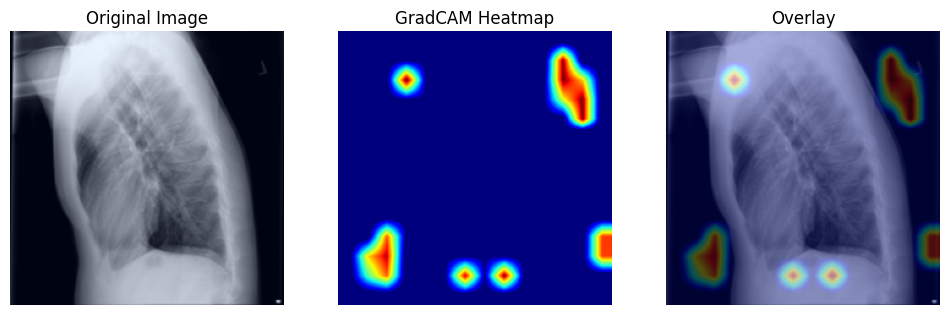

True class: normal
Predicted class: normal

Text input:
loss esr 92 trachea midline normal heart clear lungs pneumothorax pleural effusion


In [59]:

# Testing code
test_batch = next(iter(test_dataloader))
image = test_batch['image'][0]
text_tokens = {
    'input_ids': test_batch['input_ids'][0:1],
    'attention_mask': test_batch['attention_mask'][0:1]
}
true_label = test_batch['label'][0].item()

# Apply GradCAM
cam, predicted_class = apply_gradcam(
    model=classifier_model,
    image_tensor=image,
    text_tokens=text_tokens
)

# Print results
class_names = ['normal', 'diseased']
print(f"True class: {class_names[true_label]}")
print(f"Predicted class: {class_names[predicted_class]}")
print("\nText input:")
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
text = tokenizer.decode(text_tokens['input_ids'][0], skip_special_tokens=True)
print(text)

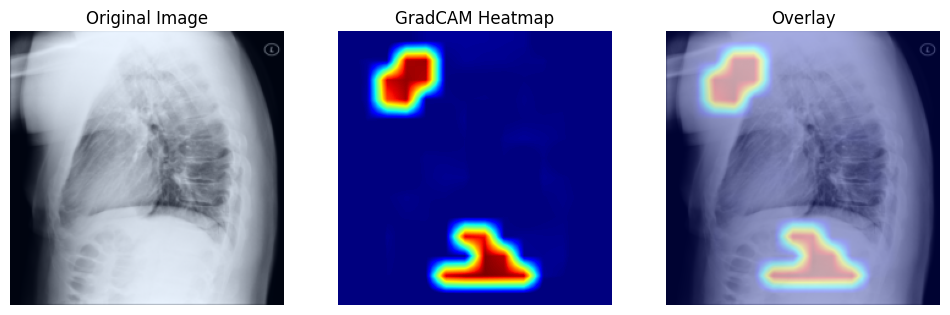

True class: diseased
Predicted class: diseased

Text input:
male pain stable cardiomediastinal silhouette normal heart size mediastinal calcifications suggest previous granulomatous process apical irregularities also present previous exam suggestive scarring focal alveolar consolidation definite pleural effusion seen typical findings pulmonary edema pneumothorax


In [60]:

# Testing code
test_batch = next(iter(test_dataloader))
image = test_batch['image'][0]
text_tokens = {
    'input_ids': test_batch['input_ids'][0:1],
    'attention_mask': test_batch['attention_mask'][0:1]
}
true_label = test_batch['label'][0].item()

# Apply GradCAM
cam, predicted_class = apply_gradcam(
    model=classifier_model,
    image_tensor=image,
    text_tokens=text_tokens
)

# Print results
class_names = ['normal', 'diseased']
print(f"True class: {class_names[true_label]}")
print(f"Predicted class: {class_names[predicted_class]}")
print("\nText input:")
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
text = tokenizer.decode(text_tokens['input_ids'][0], skip_special_tokens=True)
print(text)

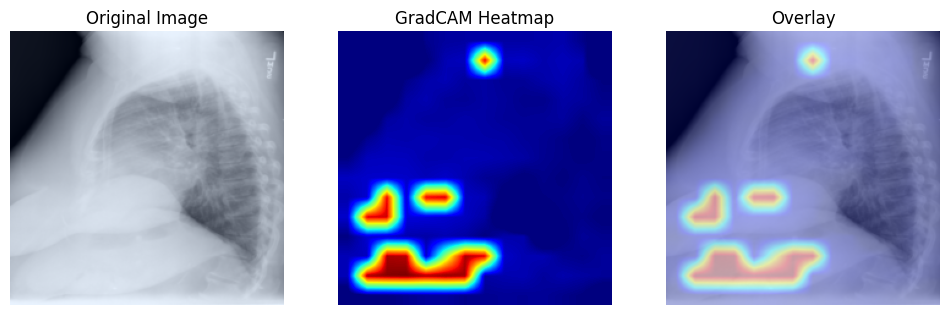

True class: diseased
Predicted class: diseased

Text input:
patient female chest unchanged elevation right hemidiaphragm trachea midline negative pneumothorax pleural effusion focal airspace consolidation heart size mildly enlarged mild degenerative changes throughout thoracic spine anterior osteophytes noted inferiorly pulmonary artery prominence


In [61]:

# Testing code
test_batch = next(iter(test_dataloader))
image = test_batch['image'][0]
text_tokens = {
    'input_ids': test_batch['input_ids'][0:1],
    'attention_mask': test_batch['attention_mask'][0:1]
}
true_label = test_batch['label'][0].item()

# Apply GradCAM
cam, predicted_class = apply_gradcam(
    model=classifier_model,
    image_tensor=image,
    text_tokens=text_tokens
)

# Print results
class_names = ['normal', 'diseased']
print(f"True class: {class_names[true_label]}")
print(f"Predicted class: {class_names[predicted_class]}")
print("\nText input:")
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
text = tokenizer.decode(text_tokens['input_ids'][0], skip_special_tokens=True)
print(text)

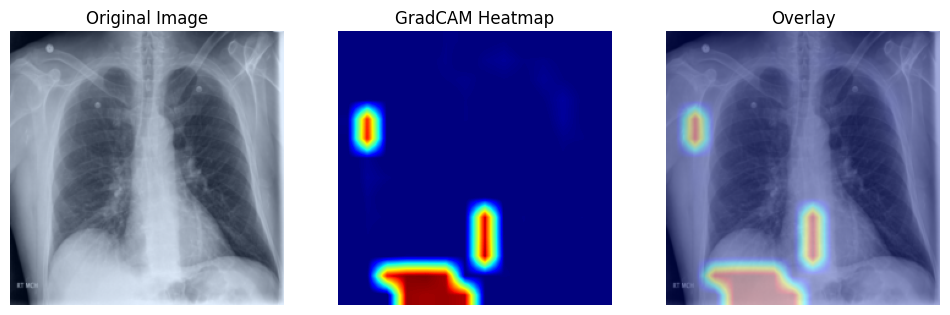

True class: diseased
Predicted class: normal

Text input:
chest pain heart normal size mediastinum unremarkable lungs clear mild eventration right hemidiaphragm pleural effusion seen


In [62]:

# Testing code
test_batch = next(iter(test_dataloader))
image = test_batch['image'][0]
text_tokens = {
    'input_ids': test_batch['input_ids'][0:1],
    'attention_mask': test_batch['attention_mask'][0:1]
}
true_label = test_batch['label'][0].item()

# Apply GradCAM
cam, predicted_class = apply_gradcam(
    model=classifier_model,
    image_tensor=image,
    text_tokens=text_tokens
)

# Print results
class_names = ['normal', 'diseased']
print(f"True class: {class_names[true_label]}")
print(f"Predicted class: {class_names[predicted_class]}")
print("\nText input:")
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
text = tokenizer.decode(text_tokens['input_ids'][0], skip_special_tokens=True)
print(text)

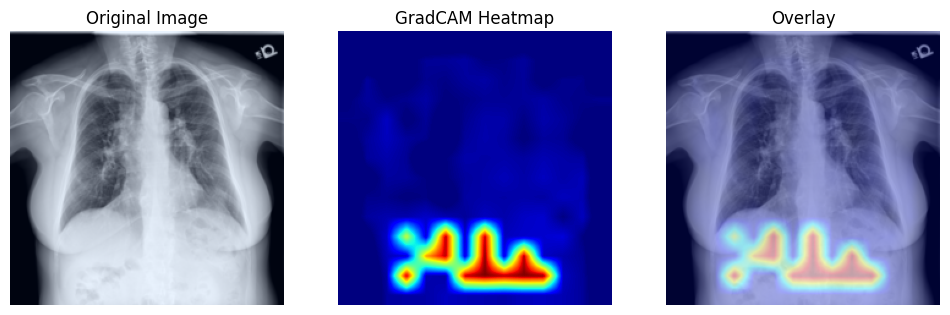

True class: diseased
Predicted class: diseased

Text input:
sarcoidosis heart size pulmonary vascularity appear within normal limits bilateral hilar fullness present consistent adenopathy appearance unchanged prominence interstitial markings bilaterally also unchanged focal superimposed airspace disease seen pneumothorax pleural effusion noted


In [63]:

# Testing code
test_batch = next(iter(test_dataloader))
image = test_batch['image'][0]
text_tokens = {
    'input_ids': test_batch['input_ids'][0:1],
    'attention_mask': test_batch['attention_mask'][0:1]
}
true_label = test_batch['label'][0].item()

# Apply GradCAM
cam, predicted_class = apply_gradcam(
    model=classifier_model,
    image_tensor=image,
    text_tokens=text_tokens
)

# Print results
class_names = ['normal', 'diseased']
print(f"True class: {class_names[true_label]}")
print(f"Predicted class: {class_names[predicted_class]}")
print("\nText input:")
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
text = tokenizer.decode(text_tokens['input_ids'][0], skip_special_tokens=True)
print(text)

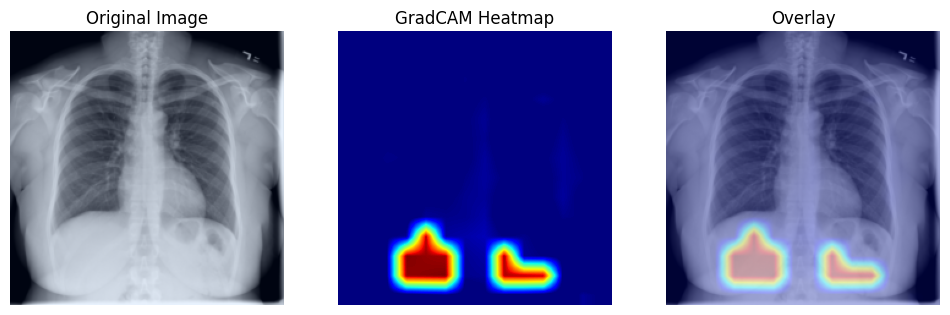

True class: normal
Predicted class: normal

Text input:
786 50 anterior left sided chest pain cardiomediastinal silhouette pulmonary vasculature within normal limits pneumothorax pleural effusion focal areas consolidation


In [64]:

# Testing code
test_batch = next(iter(test_dataloader))
image = test_batch['image'][0]
text_tokens = {
    'input_ids': test_batch['input_ids'][0:1],
    'attention_mask': test_batch['attention_mask'][0:1]
}
true_label = test_batch['label'][0].item()

# Apply GradCAM
cam, predicted_class = apply_gradcam(
    model=classifier_model,
    image_tensor=image,
    text_tokens=text_tokens
)

# Print results
class_names = ['normal', 'diseased']
print(f"True class: {class_names[true_label]}")
print(f"Predicted class: {class_names[predicted_class]}")
print("\nText input:")
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
text = tokenizer.decode(text_tokens['input_ids'][0], skip_special_tokens=True)
print(text)

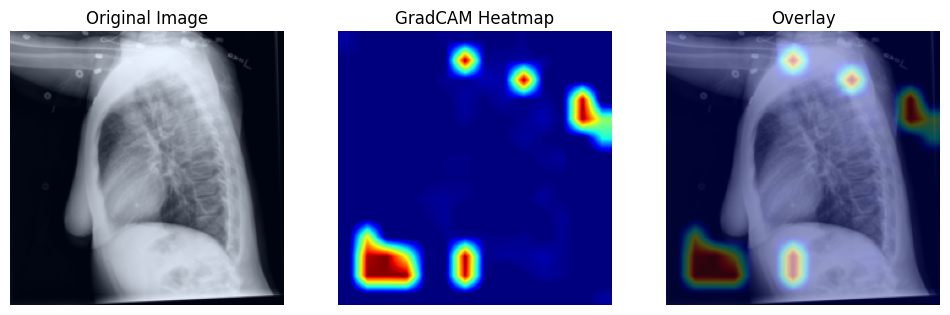

True class: diseased
Predicted class: normal

Text input:
heart mediastinum unremarkable lungs clear without infiltrate effusion pneumothorax mild levoscoliosis thoracic spine mild widening right acromioclavicular joint may postsurgical posttraumatic


In [98]:

# Testing code
test_batch = next(iter(test_dataloader))
image = test_batch['image'][0]
text_tokens = {
    'input_ids': test_batch['input_ids'][0:1],
    'attention_mask': test_batch['attention_mask'][0:1]
}
true_label = test_batch['label'][0].item()

# Apply GradCAM
cam, predicted_class = apply_gradcam(
    model=classifier_model,
    image_tensor=image,
    text_tokens=text_tokens
)

# Print results
class_names = ['normal', 'diseased']
print(f"True class: {class_names[true_label]}")
print(f"Predicted class: {class_names[predicted_class]}")
print("\nText input:")
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
text = tokenizer.decode(text_tokens['input_ids'][0], skip_special_tokens=True)
print(text)

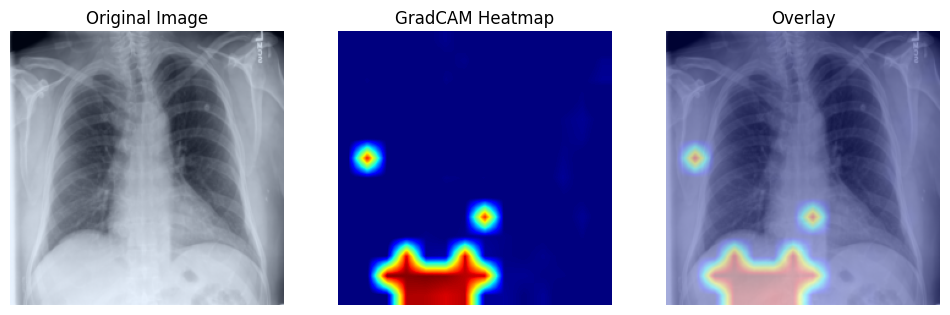

True class: normal
Predicted class: normal

Text input:
male chest pain syncope focal areas consolidation suspicious pulmonary opacities heart size within normal limits pleural effusions evidence pneumothorax osseous structures intact


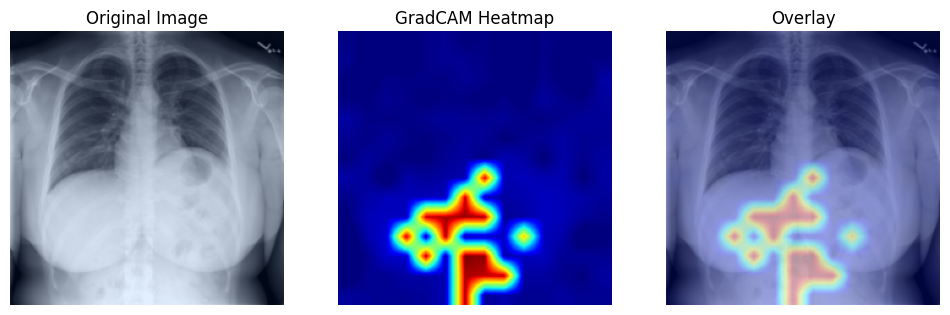

True class: diseased
Predicted class: diseased

Text input:


IndexError: index 1 is out of bounds for dimension 0 with size 1

In [104]:

# Testing code
test_batch = next(iter(test_dataloader))
for i in range(64) :
    
    image = test_batch['image'][i]
    
    
    text_tokens = {
        'input_ids': test_batch['input_ids'][i:i+1],
        'attention_mask': test_batch['attention_mask'][i:i+1]
    }
    true_label = test_batch['label'][i].item()
    
    # Apply GradCAM
    cam, predicted_class = apply_gradcam(
        model=classifier_model,
        image_tensor=image,
        text_tokens=text_tokens
    )
    
    # Print results
    class_names = ['normal', 'diseased']
    print(f"True class: {class_names[true_label]}")
    print(f"Predicted class: {class_names[predicted_class]}")
    print("\nText input:")
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    text = tokenizer.decode(text_tokens['input_ids'][i], skip_special_tokens=True)
    print(text)

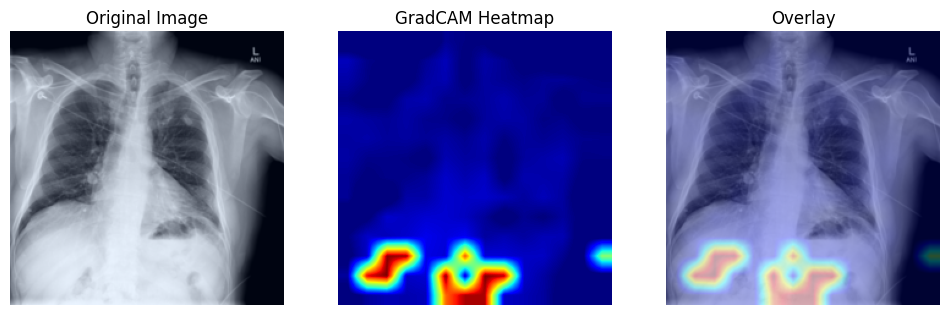

True class: diseased
Predicted class: diseased

Text input:
chest pain heart pulmonary mediastinum within normal limits pleural effusion pneumothorax focal air space opacity suggest pneumonia several age indeterminate left sided rib fractures noted calcified right hilar lymph node basilar calcified granulomas minimal degenerative changes spine


In [112]:

# Testing code
test_batch = next(iter(test_dataloader))
image = test_batch['image'][0]
text_tokens = {
    'input_ids': test_batch['input_ids'][0:1],
    'attention_mask': test_batch['attention_mask'][0:1]
}
true_label = test_batch['label'][0].item()

# Apply GradCAM
cam, predicted_class = apply_gradcam(
    model=classifier_model,
    image_tensor=image,
    text_tokens=text_tokens
)

# Print results
class_names = ['normal', 'diseased']
print(f"True class: {class_names[true_label]}")
print(f"Predicted class: {class_names[predicted_class]}")
print("\nText input:")
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
text = tokenizer.decode(text_tokens['input_ids'][0], skip_special_tokens=True)
print(text)

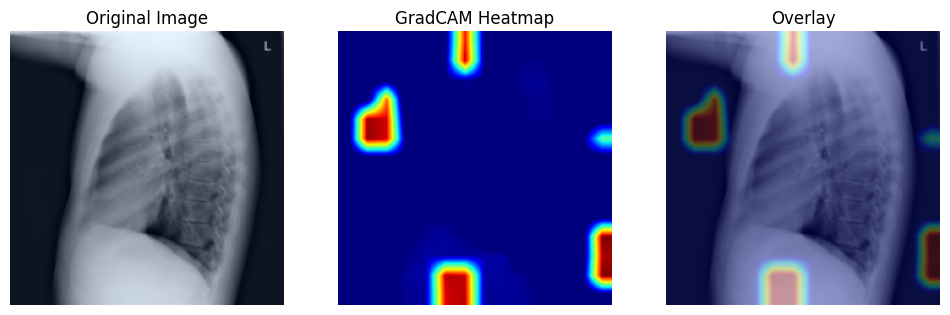

True class: normal
Predicted class: normal

Text input:
bmt w u lab


In [68]:

# Testing code
test_batch = next(iter(test_dataloader))
image = test_batch['image'][0]
text_tokens = {
    'input_ids': test_batch['input_ids'][0:1],
    'attention_mask': test_batch['attention_mask'][0:1]
}
true_label = test_batch['label'][0].item()

# Apply GradCAM
cam, predicted_class = apply_gradcam(
    model=classifier_model,
    image_tensor=image,
    text_tokens=text_tokens
)

# Print results
class_names = ['normal', 'diseased']
print(f"True class: {class_names[true_label]}")
print(f"Predicted class: {class_names[predicted_class]}")
print("\nText input:")
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
text = tokenizer.decode(text_tokens['input_ids'][0], skip_special_tokens=True)
print(text)

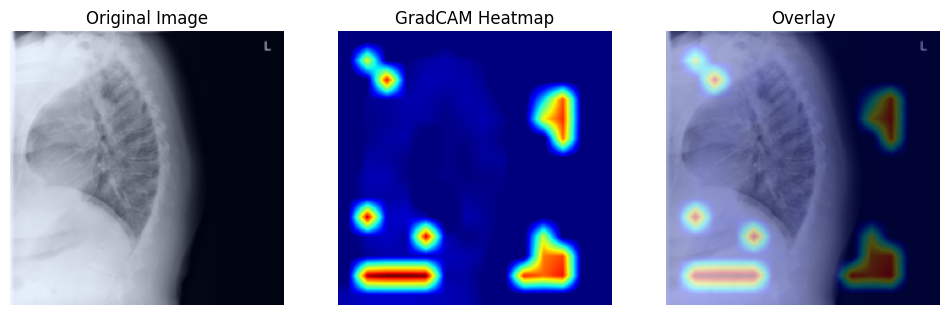

True class: normal
Predicted class: diseased

Text input:
bone marrow asymptomatic heart size cardiomediastinal silhouette pulmonary vasculature within normal limits infiltrates effusions pneumothorax


In [69]:

# Testing code
test_batch = next(iter(test_dataloader))
image = test_batch['image'][0]
text_tokens = {
    'input_ids': test_batch['input_ids'][0:1],
    'attention_mask': test_batch['attention_mask'][0:1]
}
true_label = test_batch['label'][0].item()

# Apply GradCAM
cam, predicted_class = apply_gradcam(
    model=classifier_model,
    image_tensor=image,
    text_tokens=text_tokens
)

# Print results
class_names = ['normal', 'diseased']
print(f"True class: {class_names[true_label]}")
print(f"Predicted class: {class_names[predicted_class]}")
print("\nText input:")
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
text = tokenizer.decode(text_tokens['input_ids'][0], skip_special_tokens=True)
print(text)

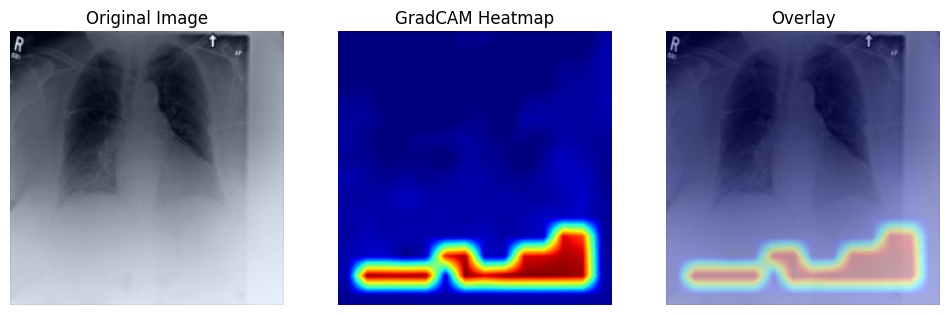

True class: diseased
Predicted class: diseased

Text input:
dyspnea heart size moderately enlarged pulmonary mediastinum within normal limits pleural effusion pneumothorax suspected right lower lobe airspace opacity demonstrated lateral study fracture superior sternotomy unchanged


In [70]:

# Testing code
test_batch = next(iter(test_dataloader))
image = test_batch['image'][0]
text_tokens = {
    'input_ids': test_batch['input_ids'][0:1],
    'attention_mask': test_batch['attention_mask'][0:1]
}
true_label = test_batch['label'][0].item()

# Apply GradCAM
cam, predicted_class = apply_gradcam(
    model=classifier_model,
    image_tensor=image,
    text_tokens=text_tokens
)

# Print results
class_names = ['normal', 'diseased']
print(f"True class: {class_names[true_label]}")
print(f"Predicted class: {class_names[predicted_class]}")
print("\nText input:")
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
text = tokenizer.decode(text_tokens['input_ids'][0], skip_special_tokens=True)
print(text)

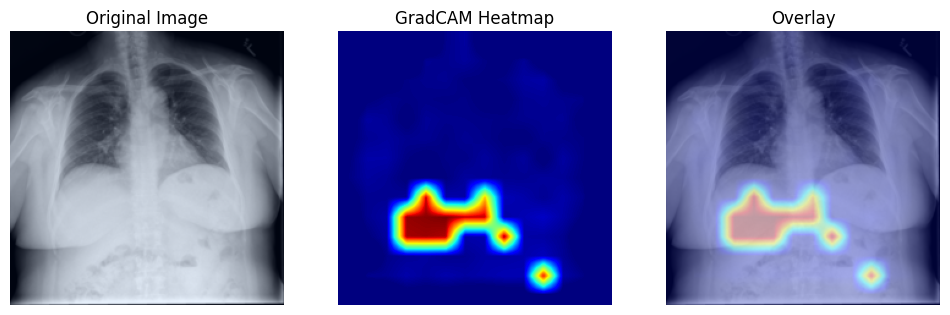

True class: diseased
Predicted class: normal

Text input:
female lung nodules cardiomediastinal silhouette within normal limits size contour lungs normally inflated without evidence focal airspace disease pleural effusion pneumothorax scattered bilateral calcified pulmonary nodules acute bone abnormality


In [71]:

# Testing code
test_batch = next(iter(test_dataloader))
image = test_batch['image'][0]
text_tokens = {
    'input_ids': test_batch['input_ids'][0:1],
    'attention_mask': test_batch['attention_mask'][0:1]
}
true_label = test_batch['label'][0].item()

# Apply GradCAM
cam, predicted_class = apply_gradcam(
    model=classifier_model,
    image_tensor=image,
    text_tokens=text_tokens
)

# Print results
class_names = ['normal', 'diseased']
print(f"True class: {class_names[true_label]}")
print(f"Predicted class: {class_names[predicted_class]}")
print("\nText input:")
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
text = tokenizer.decode(text_tokens['input_ids'][0], skip_special_tokens=True)
print(text)

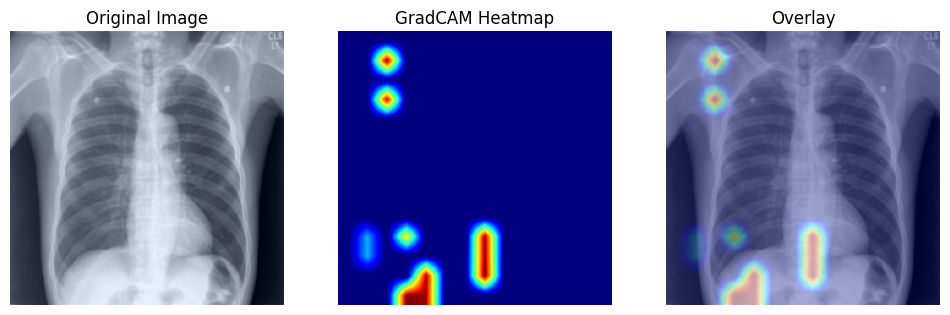

True class: normal
Predicted class: normal

Text input:
pain heart size mediastinal contours appear within normal limits pulmonary vascularity within normal limits focal consolidation suspicious pulmonary opacity pneumothorax definite pleural effusion visualized osseous structures appear intact


In [72]:

# Testing code
test_batch = next(iter(test_dataloader))
image = test_batch['image'][0]
text_tokens = {
    'input_ids': test_batch['input_ids'][0:1],
    'attention_mask': test_batch['attention_mask'][0:1]
}
true_label = test_batch['label'][0].item()

# Apply GradCAM
cam, predicted_class = apply_gradcam(
    model=classifier_model,
    image_tensor=image,
    text_tokens=text_tokens
)

# Print results
class_names = ['normal', 'diseased']
print(f"True class: {class_names[true_label]}")
print(f"Predicted class: {class_names[predicted_class]}")
print("\nText input:")
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
text = tokenizer.decode(text_tokens['input_ids'][0], skip_special_tokens=True)
print(text)

AttributeError: Can't get attribute 'TextImageClassifierDataset' on <module '__main__'>